# Prediction Comparison for UNet Versions

This plots the model segmentation predictions versus the ground truth.

We need to compare the model outputs based on doing the **up sampling operation** via:
+ [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d)
   ```
   up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
   ```
+ [Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose)
   ```
   up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
   ```
   
Intel has optimized the operations for Conv2DTranspose but not for UpSampling2D. If we can prove that the two produce similar results, then we can recommend the Intel optimization as a viable substitution.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dice(im1, im2):
    
    '''
    Do we match the binary version of the prediction mask or the probability version?
    '''
    
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = im1*im2

    smoothing_delta = 1.0
    
    return (2. * intersection.sum() + smoothing_delta) / (im1.sum() + im2.sum() + smoothing_delta)

# Loading the prediction masks and the ground truth data

The *pred.npy* files were generated by running:
```
numactl -p 1 python train.py 50 5 0
```

In [4]:
msk_upsampling = np.load('msks_pred_upsampling.npy')
#msk_upsampling = np.load('msks_pred_transposed.npy')
#msk_transposed = np.load('msks_pred_transposed.npy')
dir1 = '/mnt/data/medical/brats/Brats2016/128x128/'
test = np.load(dir1+'msks_test.npy')
imgs = np.load(dir1+'imgs_test.npy')

In [5]:
# Preprocess the segmentation masks for the ground truth (mode=1)
test[:,:,:,0] = test[:,:,:,0]+test[:,:,:,1]+test[:,:,:,2]+test[:,:,:,3]

In [6]:
threshold = 500
for idx in range(6200):
    if (np.sum(test[idx,:,:,0]) > threshold) and (np.sum(test[idx,:,:,3]) > threshold) and (np.sum(test[idx,:,:,2]) > threshold) and (np.sum(test[idx,:,:,1]) > threshold):
        print(idx)

371
372
373
374
995
1008
1009
1323
2548
2824
2825
2845
2846
2847
2848
3953
3956
3957
3958
3959
3960
3962
3963
3964
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
4395
4396
4397
4398
4399
4400
4404
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
5354
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
6103
6104
6105
6106
6107
6108
6109
6110
6111


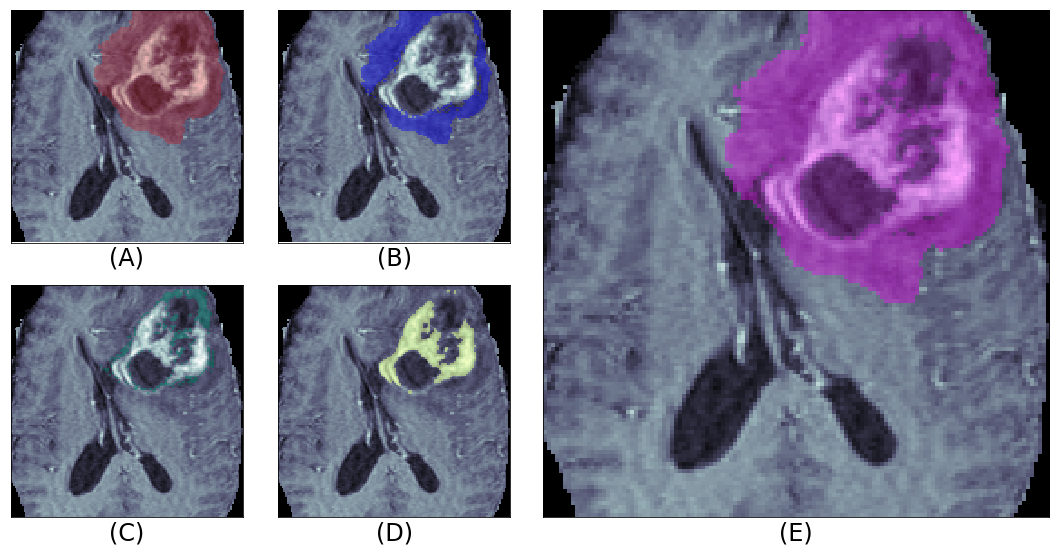

In [7]:
plt.figure(figsize=(15,15));
idx = 1323   # Good image and mask from test dataset for BraTS

fontsize = 24

plt.subplot2grid((4, 4), (0, 0), colspan=1)
plt.imshow(imgs[idx,:,:,0], cmap="bone");

layer0 = np.ma.masked_where(test[idx,:,:,0] == 0, test[idx,:,:,0])
layer1 = np.ma.masked_where(test[idx,:,:,1] == 0, test[idx,:,:,1])
layer2 = np.ma.masked_where(test[idx,:,:,2] == 0, test[idx,:,:,2])
layer3 = np.ma.masked_where(test[idx,:,:,3] == 0, test[idx,:,:,3])

plt.imshow(layer0, cmap="Set1",alpha=0.3);  # Red

plt.xlabel("(A)", fontsize=fontsize);
ax = plt.gca()
ax.xaxis.set_ticklabels([]);
ax.xaxis.set_ticks([]);
ax.yaxis.set_ticklabels([]);
ax.yaxis.set_ticks([]);

plt.subplot2grid((4, 4), (0, 1), colspan=1)
plt.imshow(imgs[idx,:,:,0], cmap="bone");
plt.imshow(layer1, cmap="bwr", alpha=0.4);  # Blue

plt.xlabel("(B)", fontsize=fontsize);
ax = plt.gca()
ax.xaxis.set_ticklabels([]);
ax.xaxis.set_ticks([]);
ax.yaxis.set_ticklabels([]);
ax.yaxis.set_ticks([]);

plt.subplot2grid((4, 4), (1, 0), colspan=1)
plt.imshow(imgs[idx,:,:,0], cmap="bone");
plt.imshow(layer2, cmap="summer", alpha=0.5);  # Green

plt.xlabel("(C)", fontsize=fontsize);
ax = plt.gca()
ax.xaxis.set_ticklabels([]);
ax.xaxis.set_ticks([]);
ax.yaxis.set_ticklabels([]);
ax.yaxis.set_ticks([]);

plt.subplot2grid((4, 4), (1, 1), colspan=1)
plt.imshow(imgs[idx,:,:,0], cmap="bone");
plt.imshow(layer3, cmap="Wistia", alpha=0.45);  # Yellow

plt.xlabel("(D)", fontsize=fontsize);
ax = plt.gca()
ax.xaxis.set_ticklabels([]);
ax.xaxis.set_ticks([]);
ax.yaxis.set_ticklabels([]);
ax.yaxis.set_ticks([]);

plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=2)
plt.imshow(imgs[idx,:,:,0], cmap="bone");

if np.sum(layer0) > 0:
    plt.imshow(layer0, cmap="spring", alpha=0.2); # Magenta
if np.sum(layer1) > 0:
    plt.imshow(layer1, cmap="spring", alpha=0.2); # Magenta
if np.sum(layer2) > 0:
    plt.imshow(layer2, cmap="spring", alpha=0.2); # Magenta
if np.sum(layer3) > 0:
    plt.imshow(layer3, cmap="spring", alpha=0.2); # Magenta


#plt.axis("off");
plt.xlabel("(E)", fontsize=fontsize);
ax = plt.gca()
ax.xaxis.set_ticklabels([]);
ax.xaxis.set_ticks([]);
ax.yaxis.set_ticklabels([]);
ax.yaxis.set_ticks([]);

plt.tight_layout()
plt.savefig("tumor_masks.png", dpi=600)

In [8]:
def imgPlusMask(img):
    
    plt.figure(figsize=(14,14))
    plt.subplot(1,2,1)
    plt.imshow(test[img,:,:,0], cmap='bone')
    plt.yticks([])
    plt.axis("off")
    plt.title('Ground truth', fontsize=24);
    plt.subplot(1,2,2)
    plt.imshow(imgs[img,:,:,0], cmap="bone");
    layer0 = np.ma.masked_where(test[img,:,:,0] == 0, test[img,:,:,0])
    plt.imshow(layer0, alpha=0.5, cmap="Wistia");
    plt.yticks([])
    plt.axis("off")
    plt.title('Image with mask', fontsize=24)

In [24]:
def comparePredictions(img):
    
    plt.figure(figsize=(14,14))
    plt.subplot(1,3,1)
    plt.imshow(msk_upsampling[img,:,:,0], cmap='bone')
    plt.axis("off")
    plt.title('Prediction UpSampling', fontsize=14)
    plt.subplot(1,3,2)
    #plt.imshow(msk_transposed[img,:,:,0], cmap='bone')
#     plt.yticks([])
#     plt.axis("off")
#     plt.title('Prediction Transposed', fontsize=14)
#     plt.subplot(1,4,3)
    plt.imshow(test[img,:,:,0], cmap='bone')
    plt.yticks([])
    plt.axis("off")
    plt.title('Ground truth', fontsize=14);
    plt.subplot(1,3,3)
    plt.imshow(imgs[img,:,:,0], cmap="bone");
    
    layer0 = np.ma.masked_where(test[img,:,:,0] == 0, test[img,:,:,0])
    if np.sum(layer0) > 0:
        plt.imshow(layer0, alpha=0.6, cmap="Wistia");
        
    plt.yticks([])
    plt.axis("off")
    plt.title('Image with mask', fontsize=14)
    plt.savefig("2d_unet_predictions_{}.png".format(img))
    
    # Calculate the Dice coefficient for the two versions
    msk_binaryU = msk_upsampling[img,:,:,0]
    print ('Dice coefficient for upsampling {}'.format(dice(msk_binaryU, test[img,:,:,0])))
    
    #msk_binaryT = msk_transposed[img,:,:,0]
    #print ('Dice coefficient for transposed {}'.format(dice(msk_binaryT, test[img,:,:,0])))
    

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plots(x):
    comparePredictions(x)
    
interact(plots, x=widgets.IntSlider(min=0,max=(np.shape(imgs)[0]-1),step=1,value=10));

A Jupyter Widget

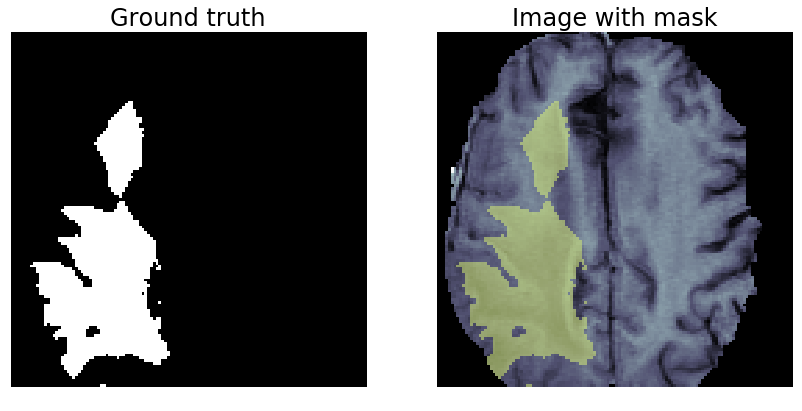

In [10]:
imgPlusMask(4444)

Dice coefficient for upsampling 0.8487666169669781


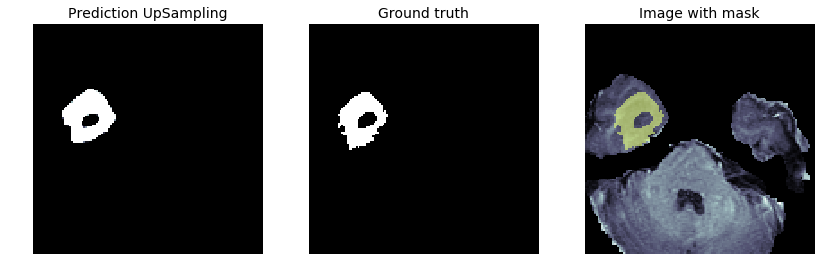

In [25]:
comparePredictions(828)

Dice coefficient for upsampling 0.94574687944383


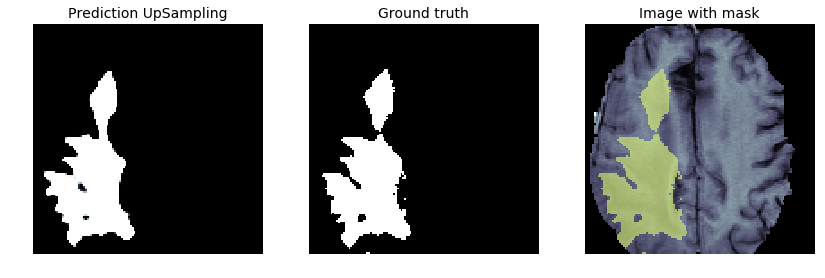

In [26]:
comparePredictions(4444)

Dice coefficient for upsampling 0.8460252650532265
Dice coefficient for transposed 0.8766095568902574


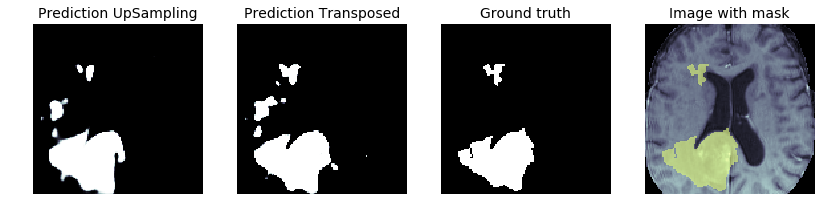

In [34]:
comparePredictions(5821)

Dice coefficient for upsampling 0.8563244965719139


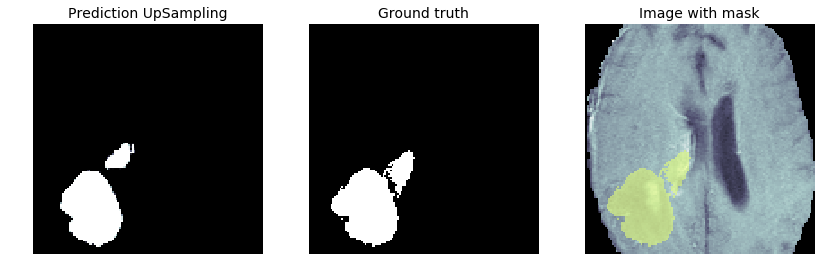

In [27]:
comparePredictions(400)

Dice coefficient for upsampling 0.7859278695255156


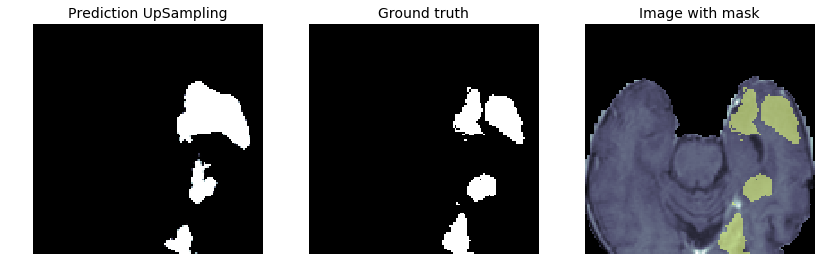

In [28]:
comparePredictions(520)

Dice coefficient for upsampling 0.9753399169997624
Dice coefficient for transposed 0.9735278598367645


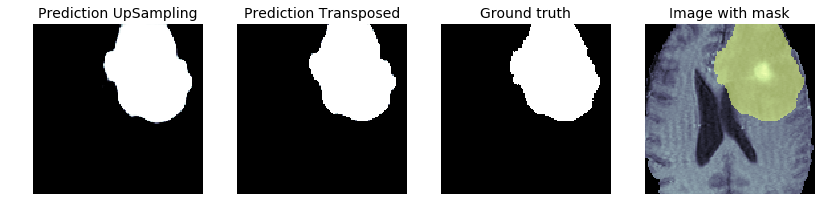

In [37]:
comparePredictions(1333)

Dice coefficient for upsampling 0.9128385084465092
Dice coefficient for transposed 0.9178177643619048


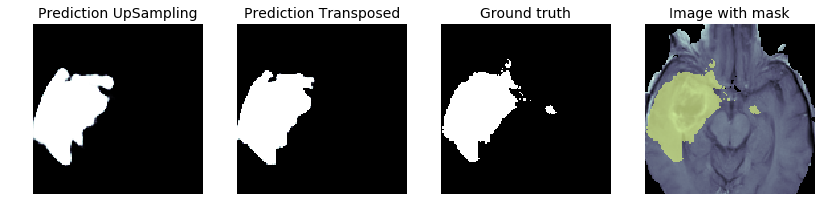

In [38]:
comparePredictions(2540)

Dice coefficient for upsampling 0.7907601210116141


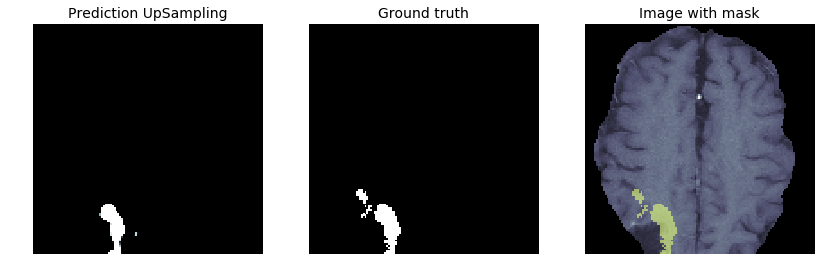

In [29]:
comparePredictions(5533)

Dice coefficient for upsampling 0.927479156226408
Dice coefficient for transposed 0.9445314973002314


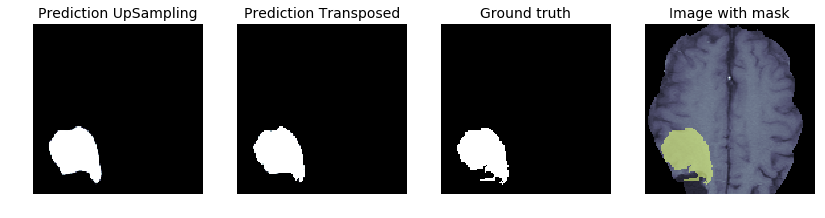

In [40]:
comparePredictions(2121)

Dice coefficient for upsampling 0.9092366623110523
Dice coefficient for transposed 0.9219152316003532


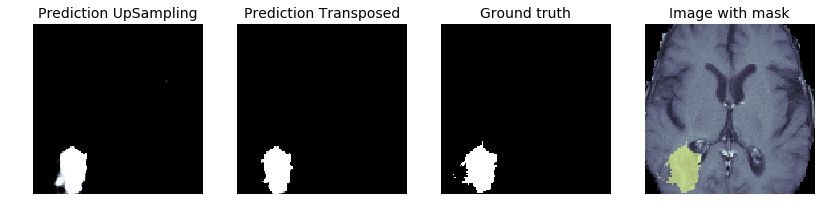

In [16]:
comparePredictions(5500)

Dice coefficient for upsampling 0.8145573563685784
Dice coefficient for transposed 0.8543099950136073


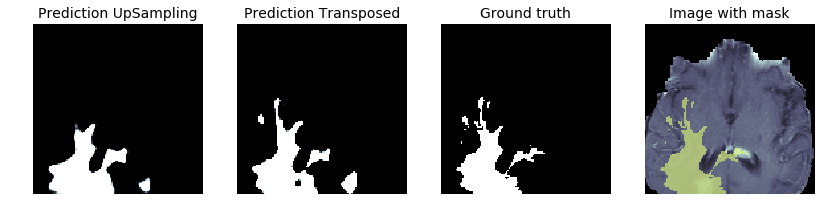

In [42]:
comparePredictions(3334)

Dice coefficient for upsampling 0.8453908062194229
Dice coefficient for transposed 0.8759253007449902


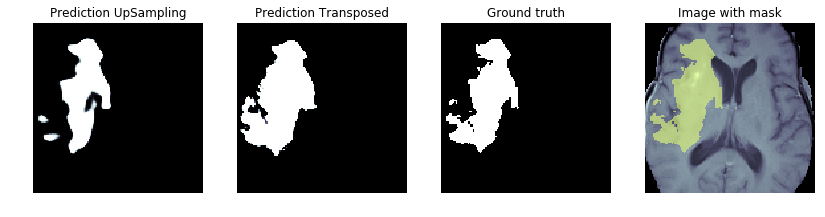

In [17]:
comparePredictions(2560)

Dice coefficient for upsampling 0.9826486798354215
Dice coefficient for transposed 0.9999996692582683


/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/numpy/ma/

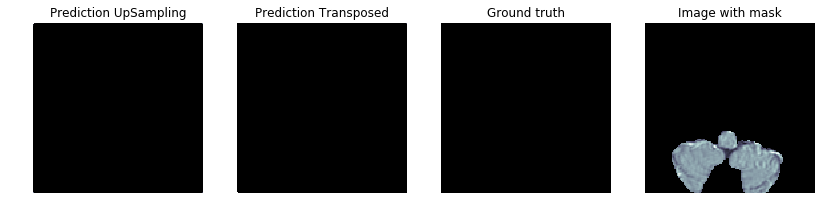

In [18]:
comparePredictions(10)

Dice coefficient for upsampling 0.2663321540026513
Dice coefficient for transposed 0.2222979758526408


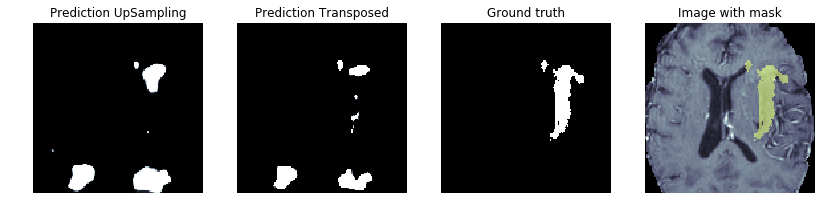

In [19]:
comparePredictions(88)

Dice coefficient for upsampling 0.9810111756017821
Dice coefficient for transposed 0.9999997670967079


/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/bduser/anaconda3/envs/tf19_mkl_p36/lib/python3.6/site-packages/numpy/ma/

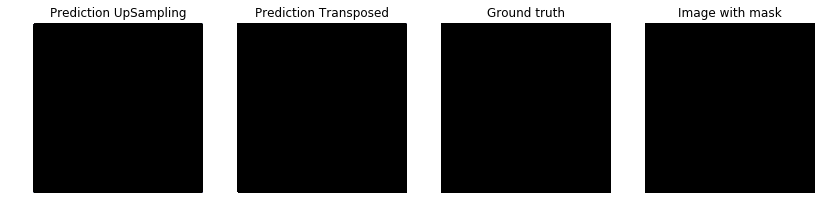

In [20]:
comparePredictions(0)

Dice coefficient for upsampling 0.12395561356756361
Dice coefficient for transposed 0.16190834336939


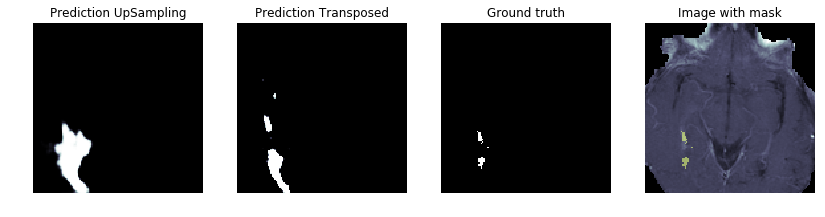

In [21]:
comparePredictions(3004)

In [43]:
dice_transposed = np.zeros(test.shape[0])
#dice_upsampling = np.zeros(test.shape[0])
mass = np.zeros(test.shape[0])

for i in range(test.shape[0]):
    
    dice_transposed[i] = dice(msk_transposed[i, :, :, 0], test[i, :, :, 0])
    #dice_upsampling[i] = dice(msk_upsampling[i, :, :, 0], test[i, :, :, 0])
    mass[i] = np.sum(test[i, :, :, 0]) # The amount of tumor pixels in the image
    

In [44]:
np.where((mass<100) & (mass > 50))

(array([  95,   96,   97,   98,   99,  100,  101,  105,  188,  189,  195,
         243,  248,  249,  256,  345,  346,  582,  754,  961, 1041, 1042,
        1118, 1282, 1429, 1430, 1431, 1585, 1661, 1662, 1800, 1888, 1941,
        1942, 1943, 1944, 2083, 2132, 2235, 2278, 2357, 2358, 2414, 2415,
        2420, 2429, 2511, 2590, 2916, 3004, 3069, 3134, 3214, 3305, 3384,
        3467, 3537, 3588, 3589, 3698, 3776, 3917, 4009, 4064, 4141, 4263,
        4264, 4265, 4318, 4376, 4377, 4378, 4465, 4572, 4573, 4574, 4732,
        4869, 4933, 4994, 5408, 5493, 5542, 5543, 5638, 5639, 5710, 5797,
        5856, 5857, 5858, 5859, 5860, 5861, 5862, 5957, 5958, 6020, 6080,
        6081, 6137, 6138, 6139, 6161, 6162, 6163]),)

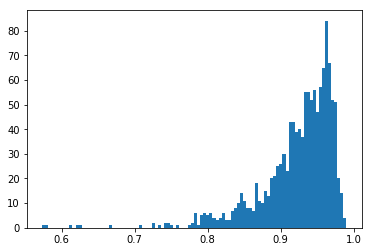

In [45]:
plt.hist(dice_transposed[mass>1470], 100);

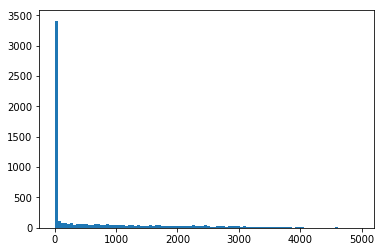

In [46]:
plt.hist(mass,100);

In [47]:
plt.figure(figsize=(12,6));
plt.hist([dice_transposed, dice_upsampling]);
plt.legend(['Conv2DTranspose', 'UpSampling2D'], fontsize=18);
plt.title('Comparing Performance of the Two Models', fontsize=18);
plt.xlabel('Dice Coefficient', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=14);

NameError: name 'dice_upsampling' is not defined

<Figure size 864x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6));
plt.hist(dice_transposed - dice_upsampling, 50);
plt.title('Dice Difference (transposed - upsampling)', fontsize=18);
plt.text(0.2, 1500, r'Transposed better $\longrightarrow$', fontsize=18);
plt.text(-.8, 1500, r'$\longleftarrow$ Upsampling better', fontsize=18);
plt.xlabel('Difference in Dice Coefficients', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=14)
plt.grid();

# Kolmogorov-Smirnoff (KS) Test

Perform a [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test) two sample test. The null hypothesis is that the two data samples come from the same distribution. 

In [ ]:
from scipy.stats import ks_2samp

ks_2samp(dice_transposed, dice_upsampling)

# Two-sided t-Test

Check if the difference between the Dice measures for each prediction is significantly different from 0.

In [ ]:
from scipy.stats import ttest_1samp

ttest_1samp(dice_transposed-dice_upsampling, 0)

In [ ]:
np.mean(dice_transposed)

In [ ]:
np.mean(dice_upsampling)

# Where are most of the poor predictions coming from?

It looks like when the Dice coefficient is low that typically there is not enough of a segmentation mask to make a sufficiently good prediction. To measure this, I calculated the "mass" of the segmentation map (i.e. just counted how many pixels were in the mask). Low dice scores were highly correlated with smaller segmentation masks.

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(mass[np.where(dice_upsampling < 0.25)], bins=10, alpha=0.8);
plt.hist(mass[np.where(dice_upsampling >= 0.25)], bins=10, alpha=0.8);
plt.title('Poor predictions are correlated with small predictions masks', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=12);
plt.xlabel('Number of pixels in ground truth segmentation mask', fontsize=12);
plt.legend(['\lt 0.25', '\ge 0.25'], title='Dice coefficient', fontsize=14);